## In a previous notebook, we demonstrated how Triglav can be used to calculate feature stability scores. We showed that Triglav will produce a set of stable features. In this notebook, we will run a simple analysis of the gut microbiomes of patients suffering from Crohn's Disease and compare that to healthy controls. We will select a set of non-redundant (one feature per cluster) features using Triglav's first and second stage. Finally, we will demonstrate how Triglav can be used with other tools to analyze which features are important and how these features can explain a sample's location in a projected space. ASVs and taxonomic assignments were created using FASTQ files analyzed with the MetaWorks pipeline (available here: https://github.com/terrimporter/MetaWorks)

#### Import required packages

In [1]:
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import LinearSVC

from TreeOrdination import TreeOrdination

from stability import hypothesisTestT, getStability, confidenceIntervals

from triglav import Triglav, ETCProx

import shap as sh

import sage as sg

import numpy as np

import pandas as pd

from random import shuffle

import seaborn as sns

from matplotlib import pyplot as plt

from skbio.stats.composition import clr, multiplicative_replacement, closure
from skbio.stats import subsample_counts

from statsmodels.stats.multitest import multipletests

d:\miniconda3\envs\testLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\miniconda3\envs\testLM\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
d:\miniconda3\envs\testLM\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba

#### Read in taxonomic data and select high-confidence ASVs

In [2]:
# Function for rarefaction
# https://stackoverflow.com/questions/15507993/quickly-rarefy-a-matrix-in-numpy-python
from numpy.random import RandomState

def rarefaction(M, y1, M2, y2, D, seed=0):
    prng = RandomState(seed)  # reproducible results

    n_occur = M.sum(axis=1)
    rem = np.where(n_occur < D, False, True)
    M_ss = M[rem]
    n_occur = n_occur[rem]
    nvar = M.shape[1]  # number of variables

    # Do training data
    Mrarefied = np.empty_like(M_ss)
    for i in range(M_ss.shape[0]):  # for each sample
        p = M_ss[i] / float(n_occur[i])  # relative frequency / probability
        choice = prng.choice(nvar, D, p=p)
        Mrarefied[i] = np.bincount(choice, minlength=nvar)

    # Do testing data
    n_occur2 = M2.sum(axis=1)
    rem2 = np.where(n_occur2 < D, False, True)
    M_ss2 = M2[rem2]
    n_occur2 = n_occur2[rem2]
    nvar = M2.shape[1]  # number of variables

    Mrarefied2 = np.empty_like(M_ss2)
    for i in range(M_ss2.shape[0]):  # for each sample
        p = M_ss2[i] / float(n_occur2[i])  # relative frequency / probability
        choice = prng.choice(nvar, D, p=p)
        Mrarefied2[i] = np.bincount(choice, minlength=nvar)

    return Mrarefied, y1[rem], Mrarefied2, y2[rem2]

if __name__ == "__main__":

    #Read in ASV table
    X = pd.read_csv("Diseased Gut/ESV.table", index_col=0, sep="\t")
    X_features = X.index.values #Get features
    X_index = [s_name.split("_")[0] for s_name in X.columns.values] #Get the right index
    X_original = X.transpose()
    X_original.index = X_index #Fix the index so it can be ordered
    
    # Read in taxa data
    taxa_tab = pd.read_csv(
        "Diseased Gut/rdp.out.tmp", delimiter="\t", header=None
    ).values

    #Convert taxa tab into a dictionary for quick searching
    taxa_dict = {t[0]: np.asarray(t)[1:] for t in taxa_tab}
    
    # Keep all ASVs assigned to Bacteria and Archaea, remove Cyanobacteria and Chloroplasts
    idx = np.where(
        ((taxa_tab[:, 2] == "Bacteria") | (taxa_tab[:, 2] == "Archaea")), True, False
    )
    taxa_tab = taxa_tab[idx]
    idx = np.where(taxa_tab[:, 5] != "Cyanobacteria/Chloroplast", True, False)
    taxa_tab = taxa_tab[idx]
    X_selected = set([x[0] for x in taxa_tab])
    taxa_tab_ss = {x[0]: x for x in taxa_tab}

    # Get names of high confidence features
    n_list = [4, 7, 10, 13, 16, 19]
    asv_name = []

    for entry in X_features:
        if entry in taxa_dict:
            if float(taxa_dict[entry][-1]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-3], entry))

            elif float(taxa_dict[entry][-4]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-6], entry))

            elif float(taxa_dict[entry][-7]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-9], entry))

            elif float(taxa_dict[entry][-10]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-12], entry))

            elif float(taxa_dict[entry][-13]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-15], entry))

            else:
                asv_name.append("Unclassified-%s" % entry)
    
    asv_name = np.asarray(asv_name)

In [3]:
    print(asv_name.shape)
    print(X_features.shape)
    print(X_original.shape)
    print(X_original)
    print(asv_name)

(3318,)
(3318,)
(214, 3318)
#OTU ID     Zotu1  Zotu10  Zotu100  Zotu1000  Zotu1001  Zotu1002  Zotu1003   
SRR8534033    926       1        0         0         0         0         0  \
SRR8534034  38586      14        1         0         0         0         0   
SRR8534035  49718    1069        1         0         2         0         0   
SRR8534036   1016     236        0         0         0         0         0   
SRR8534037   4247    3416        0         0         0         0         0   
...           ...     ...      ...       ...       ...       ...       ...   
SRR8534250   5231    2880        0         0         1         0         0   
SRR8534251    636     145        0         0         0         0         0   
SRR8534252   3026     347      332         0         0         0         0   
SRR8534253    111     163        0         0         0         0         0   
SRR8534254  12386    2485        0         0         0         0         0   

#OTU ID     Zotu1004  Zotu1005  Zot

#### Read in metadata and order X

In [4]:
    # Read in metadata
    meta = pd.read_csv("Diseased Gut/metadata.csv", index_col=0)
    meta = meta[["Sample Name", "Host_disease", "Timepoint"]]

    # Correct locations so they are more informative
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "CD", "Crohn's Disease", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "RA", "Rheumatoid Arthritis", meta["Host_disease"]
    )
    meta["Host_diseaes"] = np.where(
        meta["Host_disease"] == "MS", "Multiple Sclerosis", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "US", "Ulcerative Colitis", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "HC", "Healthy Control", meta["Host_disease"]
    )
    
    #Order samples according to the metadata
    X_original = X_original.loc[meta.index]


In [5]:
    print(meta)
    print(X_original)

            Sample Name          Host_disease  Timepoint          Host_diseaes
SRR8534151       1003.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
SRR8534152       1003.2  Rheumatoid Arthritis          2  Rheumatoid Arthritis
SRR8534149       1021.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
SRR8534083       1021.2  Rheumatoid Arthritis          2  Rheumatoid Arthritis
SRR8534155       1024.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
...                 ...                   ...        ...                   ...
SRR8534199       8399.2                    UC          2                    UC
SRR8534200       8407.1       Crohn's Disease          1       Crohn's Disease
SRR8534125       8407.2       Crohn's Disease          2       Crohn's Disease
SRR8534128       8702.1                    UC          1                    UC
SRR8534126       8702.2                    UC          2                    UC

[198 rows x 4 columns]
#OTU ID     Zotu1  Zotu10  Z

#### Get the group metadata (Sample Name)

In [6]:
    # Get groups
    groups = meta["Sample Name"].astype(str).values
    groups = np.asarray([x.split(".")[0] for x in groups])
    
    # List of phenotypes/datasets to test
    pheno = "Crohn's Disease-Healthy Control"

    pheno_a, pheno_b = pheno.split("-")

    idx = np.where(
        ((meta["Host_disease"] == pheno_a) | (meta["Host_disease"] == pheno_b)),
        True,
        False,
    )

    y = meta[idx]["Host_disease"]
    y = y.values
    
    X_signal = X_original[idx]
    
    groups = groups[idx]


In [7]:
    print(y)
    print(groups)
    print(X_signal)

['Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 "Crohn's Disease" "Crohn's Disease" 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disea

#### Remove useless features

In [8]:
    # Remove very rare ASVs (<= 4 occurances)
    X_removed = np.where(X_signal.values > 0, True, False)
    occ = np.where(X_removed.sum(axis = 0) > 4, True, False)
    X_removed = X_signal.values[:, occ]
    reduced_features = asv_name[occ]
    
    print("All Features: ", X_signal.shape[1])
    print("Reduced Features: ", X_removed.shape[1])
 

All Features:  3318
Reduced Features:  938


#### Prepare the nature-based solutions to be tested

In [9]:
    from mealpy.swarm_based import PSO, ABC
    from mealpy.swarm_based.NMRA import ImprovedNMRA
    from mealpy.swarm_based.GWO import GWO_WOA
    from mealpy.utils.logger import Logger
    from mealpy.utils.problem import Problem
    
    from sklearn.svm import LinearSVC
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, cross_validate
    from sklearn.metrics import make_scorer, pairwise_distances
    from sklearn.ensemble import StackingClassifier
    
    from skrebate import MultiSURF
    
    from skbio.stats.distance._cutils import permanova_f_stat_sW_cy
    from skbio.stats.distance._base import _preprocess_input_sng
    from skbio.stats.ordination import pcoa
    from skbio import DistanceMatrix
    
    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    
    def f_stat(X, y):
        
        D = DistanceMatrix(pairwise_distances(X, metric = "euclidean").astype(np.float32))
        
        SST = D[:] ** 2
        SST = SST.sum() / X.shape[0]
        SST = SST / 2.0
        
        n_groups, grouping = _preprocess_input_sng(D.ids, X.shape[0], y, None)
        
        grouping = np.asarray(grouping)
        
        group_sizes = np.bincount(grouping)
        
        SSW = permanova_f_stat_sW_cy(DistanceMatrix(D).data,
                                     group_sizes, 
                                     grouping)
        
        SSA = SST - SSW
        
        return (SSW / (X.shape[0] - n_groups)) / (SSA / (n_groups - 1)) # To turn this into a minimization problem
     
 
    from sklearn.utils import resample
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import log_loss
    class DSFSProblem(Problem):

        SUPPORTED_ARRAY = (list, tuple, np.ndarray)

        def __init__(self, lb=None, ub=None, minmax="min", X=None, y=None, **kwargs):
            r"""Initialize Problem.

            Args:
                lb (numpy.ndarray, list, tuple): Lower bounds of the problem.
                ub (numpy.ndarray, list, tuple): Upper bounds of the problem.
                minmax (str): Minimization or maximization problem (min, max)
                name (str): Name for this particular problem
            """
            self.name, self.log_to, self.log_file = "P", "console", "history.txt"
            self.n_objs, self.obj_is_list, self.multi_objs = 1, False, False
            self.n_dims, self.lb, self.ub, self.save_population = None, None, None, False
            self.X, self.y = X, y
            self.obj_weights = [0.6, 0.4]

            self.__set_keyword_arguments(kwargs)
            self.__set_domain_range(lb, ub)
            self.__set_functions(kwargs)
            self.logger = Logger(self.log_to, log_file=self.log_file).create_logger(name=f"{__name__}.{__class__.__name__}",
                                        format_str='%(asctime)s, %(levelname)s, %(name)s [line: %(lineno)d]: %(message)s')
            self.minmax = minmax

        def __set_keyword_arguments(self, kwargs):
            for key, value in kwargs.items():
                setattr(self, key, value)

        def __set_domain_range(self, lb, ub):
            if type(lb) in self.SUPPORTED_ARRAY and type(ub) in self.SUPPORTED_ARRAY:
                self.lb = np.array(lb).flatten()
                self.ub = np.array(ub).flatten()
                if len(self.lb) == len(self.ub):
                    self.n_dims = len(self.lb)
                    if len(self.lb) < 1:
                        raise ValueError(f'Dimensions do not qualify. Length(lb) = {len(self.lb)} < 1.')
                else:
                    raise ValueError(f"Length of lb and ub do not match. {len(self.lb)} != {len(self.ub)}.")
            else:
                raise ValueError(f"lb and ub need to be a list, tuple or np.array.")

        def __set_functions(self, kwargs):
            tested_solution = self.generate_position(self.lb, self.ub)
            if "amend_position" in kwargs:
                if not callable(self.amend_position):
                    raise ValueError(f"Use default 'amend_position()' or passed a callable function. {type(self.amend_position)} != function")
                else:
                    tested_solution = self.amend_position(tested_solution, self.lb, self.ub)
            result = self.fit_func(tested_solution)
            if type(result) in self.SUPPORTED_ARRAY:
                result = np.array(result).flatten()
                self.n_objs = len(result)
                self.obj_is_list = True
                if self.n_objs > 1:
                    self.multi_objs = True
                    if type(self.obj_weights) in self.SUPPORTED_ARRAY:
                        self.obj_weights = np.array(self.obj_weights).flatten()
                        if self.n_objs != len(self.obj_weights):
                            raise ValueError(f"{self.n_objs}-objective problem, but N weights = {len(self.obj_weights)}.")
                        self.msg = f"Solving {self.n_objs}-objective optimization problem with weights: {self.obj_weights}."
                    else:
                        raise ValueError(f"Solving {self.n_objs}-objective optimization, need to set obj_weights list with length: {self.n_objs}")
                elif self.n_objs == 1:
                    self.multi_objs = False
                    self.obj_weights = np.ones(1)
                    self.msg = f"Solving single objective optimization problem."
                else:
                    raise ValueError(f"fit_func needs to return a single value or a list of values list")
            elif type(result) in (int, float) or isinstance(result, np.floating) or isinstance(result, np.integer):
                self.multi_objs = False
                self.obj_is_list = False
                self.obj_weights = np.ones(1)
                self.msg = f"Solving single objective optimization problem."
            else:
                raise ValueError(f"fit_func needs to return a single value or a list of values list")

        def fit_func(self, x):
            """Fitness function

            Args:
                x (numpy.ndarray): Solution.

            Returns:
                float: Function value of `x`.
            """
            selected = x > 0
            
            num_selected = selected.sum()
            if num_selected == 0:
                return 1.0           
                
            # Subset
            x_train = self.X[:, selected].astype(float)
                
            # Train
            c1 = cross_validate(ExtraTreesClassifier(128, max_depth = 3), 
                               x_train, self.y, 
                               cv = 3, 
                               scoring = "balanced_accuracy",
                               return_estimator = True,
                               return_indices = True,
                               n_jobs = 5)
            
            test_ind = [inds for inds in c1["indices"]["test"]]
            log_losses_1 = [log_loss(self.y[test_ind[i]], c1["estimator"][i].predict_proba(x_train[test_ind[i]])) for i in range(3)]
            log_losses_1 = np.asarray(log_losses_1).mean()
            
            # Score
            s_1 = 1 - c1["test_score"].mean()
            s_2 = np.asarray(log_losses_1).mean()
            s_3 = f_stat(x_train, self.y)

            num_features = self.X.shape[1]          
            f_frac = num_selected / num_features

            o_1 = (0.85 * s_1) + (0.10 * s_2) + (0.05 * s_3)
            o_4 = f_frac
            
            return o_1, o_4

        def get_name(self):
            """
            Returns:
                string: The name of the problem
            """
            return self.name

        def get_class_name(self):
            """Get class name."""
            return self.__class__.__name__

        def generate_position(self, lb=None, ub=None):
            """
            Generate the position depends on the problem. For discrete problem such as permutation, this method can be override.

            Args:
                lb: list of lower bound values
                ub: list of upper bound values

            Returns:
                np.array: the position (the solution for the problem)
            """
            pos = np.random.uniform(lb, ub)
            pos = np.where(pos > 0.4, 1, 0)
            
            return pos

        def amend_position(self, position=None, lb=None, ub=None):
            """
            The goal is to transform the solution into the right format corresponding to the problem.
            For example, with discrete problems, floating-point numbers must be converted to integers
            to ensure the solution is in the correct format.

            Args:
                position: vector position (location) of the solution.
                lb: list of lower bound values
                ub: list of upper bound values

            Returns:
                Amended position (make the right format of the solution)
            """
            position_clipped = np.where(position > 0.4, 1, 0)
            
            return position_clipped
    
    

#### Identify best number of clusters parameter for feature stability in Triglav

In [ ]:
    tmp_base = {}

    idx_original_vec = np.asarray([i for i in range(X_removed.shape[1])])
    
    for n_clusters in [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]:
        counter = 0
        
        selected_features = []
        
        splitter = StratifiedGroupKFold(n_splits = 5, random_state = n_clusters, shuffle = True)
        
        for train, test in splitter.split(X_removed, y, groups):
            counter += 1
            
            X_train = X_removed[train]
            y_train = y[train]
            
            X_test = X_removed[test]
            y_test = y[test]
            
            D = int(np.percentile(X_train.sum(axis = 1), 15))

            X_train, y_train, X_test, y_test = rarefaction(X_train, y_train, X_test, y_test, D)

            X_train = np.where(X_train > 0, 1, 0)
            X_test = np.where(X_test > 0, 1, 0)
            
            X_rem = np.where(X_train.sum(axis = 0) == 0, False, True)
            X_train = X_train[:, X_rem]
            X_test = X_test[:, X_rem]
            
            print("%d %d - Remaining Features = %d" %(n_clusters, counter, X_rem.sum()))
            
            tg_model = Triglav(n_jobs = 15,
                       estimator = ExtraTreesClassifier(512, max_depth = 2, bootstrap = True), # Bootstrap is set to true to increase randomization
                       verbose = 3,
                       n_iter_fwer = 5, # A lower value will result in a more conservative selection of clusters
                       p_1 = 0.7, # A higher value will result in a more conservative selection of clusters
                       p_2 = 0.4, # A higher value will result in more clusters being rejected
                       metric = "euclidean",
                       linkage = "ward",
                       criterion = "maxclust",
                       run_stage_2 = False, 
                       alpha = 0.01, # A lower value will result in a more conservative selection of clusters
                       thresh = n_clusters) # This value will control the number of clusters.
            
            tg_model.fit(X_train, y_train)
            
            select_vec = np.zeros(shape = (X_removed.shape[1]), dtype = int)
            
            sel = idx_original_vec[X_rem]
            sel = sel[tg_model.selected_]
            for idx in sel:
                select_vec[idx] = 1
                
            selected_features.append(select_vec)
            
        tmp_base[n_clusters] = selected_features            

10 1 - Remaining Features = 732
Stage One: Identifying an initial set of tentative features...
Round 1 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 2 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 3 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 4 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 5 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 6 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 7 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 8 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 9 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 10 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 11 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 12 / Tentative (Accepted): 0

Round 20 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 21 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 22 / Tentative (Accepted): 0 / Tentative (Not Accepted): 10 / Rejected: 0
Round 23 / Tentative (Accepted): 0 / Tentative (Not Accepted): 8 / Rejected: 2
Round 24 / Tentative (Accepted): 0 / Tentative (Not Accepted): 8 / Rejected: 2
Round 25 / Tentative (Accepted): 0 / Tentative (Not Accepted): 8 / Rejected: 2
Round 26 / Tentative (Accepted): 0 / Tentative (Not Accepted): 8 / Rejected: 2
Round 27 / Tentative (Accepted): 0 / Tentative (Not Accepted): 8 / Rejected: 2
Round 28 / Tentative (Accepted): 0 / Tentative (Not Accepted): 8 / Rejected: 2
Round 29 / Tentative (Accepted): 0 / Tentative (Not Accepted): 8 / Rejected: 2
Round 30 / Tentative (Accepted): 0 / Tentative (Not Accepted): 8 / Rejected: 2
Round 31 / Tentative (Accepted): 0 / Tentative (Not Accepted): 7 / Rejected: 3


In [ ]:
    for n_clusters, selection_vecs in tmp_base.items():
          
        conf = confidenceIntervals(selection_vecs)
        
        print("%s: " %n_clusters, conf["stability"], "CI: ", conf["lower"], "-", conf["upper"])
        

#### Identify the best distance metric for feature clustering

In [ ]:
    tmp_base = {}

    idx_original_vec = np.asarray([i for i in range(X_removed.shape[1])])
    
    for metric in ["cityblock", "correlation", 
                       "cosine", "mahalanobis", "euclidean"]:
        for linkage in ["complete", "average", "single"]:
            counter = 0

            selected_features = []

            splitter = StratifiedGroupKFold(n_splits = 5, random_state = counter, shuffle = True)

            for train, test in splitter.split(X_removed, y, groups):
                counter += 1

                X_train = X_removed[train]
                y_train = y[train]

                X_test = X_removed[test]
                y_test = y[test]

                D = int(np.percentile(X_train.sum(axis = 1), 15))

                X_train, y_train, X_test, y_test = rarefaction(X_train, y_train, X_test, y_test, D)

                X_train = np.where(X_train > 0, 1, 0)
                X_test = np.where(X_test > 0, 1, 0)

                X_rem = np.where(X_train.sum(axis = 0) == 0, False, True)
                X_train = X_train[:, X_rem]
                X_test = X_test[:, X_rem]

                print("%s-%s %d - Remaining Features = %d" %(metric, linkage, counter, X_rem.sum()))

                tg_model = Triglav(n_jobs = 10,
                           estimator = ExtraTreesClassifier(512, max_depth = 2, bootstrap = True), # Bootstrap is set to true to increase randomization
                           verbose = 3,
                           n_iter_fwer = 5, # A lower value will result in a more conservative selection of clusters
                           p_1 = 0.7, # A higher value will result in a more conservative selection of clusters
                           p_2 = 0.4, # A higher value will result in more clusters being rejected
                           metric = n_clusters,
                           linkage = linkage,
                           criterion = "maxclust",
                           run_stage_2 = False, 
                           alpha = 0.01, # A lower value will result in a more conservative selection of clusters
                           thresh = 650) # This value will control the number of clusters.

                tg_model.fit(X_train, y_train)

                select_vec = np.zeros(shape = (X_removed.shape[1]), dtype = int)

                sel = idx_original_vec[X_rem]
                sel = sel[tg_model.selected_]
                for idx in sel:
                    select_vec[idx] = 1

                selected_features.append(select_vec)

            tmp_base["%s-%s" %(metric, linkage)] = selected_features            

In [ ]:
    for n_clusters, selection_vecs in tmp_base.items():
          
        conf = confidenceIntervals(selection_vecs)
        
        print("%s: " %n_clusters, conf["stability"], "CI: ", conf["lower"], "-", conf["upper"])
        

#### Identify the best model to use

In [ ]:
    from sklearn.svm import LinearSVC
    from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
    
    tmp_base = {}

    idx_original_vec = np.asarray([i for i in range(X_removed.shape[1])])
    
    est_names = ["LinearSVC", "Logistic Regression", "Ridge Classifier", "ETC 512/2", "ETC 512/3",
                 "ETC 512/5", "ETC 512/10", "ETC 512", "ETC 512/3/B", "ETC 512/2/B"]
    
    for i, estimator in enumerate([LinearSVC(dual = "auto", max_iter = 3000), LogisticRegressionCV(multi_class = "multinomial", max_iter = 3000), RidgeClassifierCV(),
                       ExtraTreesClassifier(512, max_depth = 2), ExtraTreesClassifier(512, max_depth = 3),
                       ExtraTreesClassifier(512, max_depth = 5), ExtraTreesClassifier(512, max_depth = 10),
                       ExtraTreesClassifier(512),  ExtraTreesClassifier(512, max_depth = 3, bootstrap = True),
                       ExtraTreesClassifier(512, max_depth = 2, bootstrap = True)]):
        
        estimator_name = est_names[i]
        
        counter = 0
        
        selected_features = []
        
        splitter = StratifiedGroupKFold(n_splits = 5, random_state = n_clusters, shuffle = True)
        
        for train, test in splitter.split(X_removed, y, groups):
            counter += 1
            
            X_train = X_removed[train]
            y_train = y[train]
            
            X_test = X_removed[test]
            y_test = y[test]
            
            D = int(np.percentile(X_train.sum(axis = 1), 15))

            X_train, y_train, X_test, y_test = rarefaction(X_train, y_train, X_test, y_test, D)

            X_train = np.where(X_train > 0, 1, 0)
            X_test = np.where(X_test > 0, 1, 0)
            
            X_rem = np.where(X_train.sum(axis = 0) == 0, False, True)
            X_train = X_train[:, X_rem]
            X_test = X_test[:, X_rem]
            
            print("%s %d - Remaining Features = %d" %(estimator_name, counter, X_rem.sum()))
            
            tg_model = Triglav(n_jobs = 10,
                       estimator = estimator, # Bootstrap is set to true to increase randomization
                       verbose = 3,
                       n_iter_fwer = 5, # A lower value will result in a more conservative selection of clusters
                       p_1 = 0.7, # A higher value will result in a more conservative selection of clusters
                       p_2 = 0.4, # A higher value will result in more clusters being rejected
                       metric = "mahalanobis",
                       linkage = "complete",
                       criterion = "maxclust",
                       run_stage_2 = False, 
                       alpha = 0.01, # A lower value will result in a more conservative selection of clusters
                       thresh = 650) # This value will control the number of clusters.
            
            tg_model.fit(X_train, y_train)
            
            select_vec = np.zeros(shape = (X_removed.shape[1]), dtype = int)
            
            sel = idx_original_vec[X_rem]
            sel = sel[tg_model.selected_]
            for idx in sel:
                select_vec[idx] = 1
                
            selected_features.append(select_vec)
            
        tmp_base[estimator_name] = selected_features            

In [ ]:
    for n_clusters, selection_vecs in tmp_base.items():
          
        conf = confidenceIntervals(selection_vecs)
        
        print("%s: " %n_clusters, conf["stability"], "CI: ", conf["lower"], "-", conf["upper"])

#### Test to see if there are differences between algorithms

In [ ]:
    # Import other FS algorithms
    from sklearn.feature_selection import SelectKBest, SelectFdr, RFE, RFECV, mutual_info_classif, f_classif
    from boruta import BorutaPy
    
    from functools import partial
    mi_partial = partial(mutual_info_classif, discrete_features = True)
    
    tmp_base = []

    idx_original_vec = np.asarray([i for i in range(X_removed.shape[1])])
    
    # Test population size
    overlaps = {}
    
    for i in range(5):
        print(i)
        
        splitter = StratifiedGroupKFold(n_splits = 5, random_state = i, shuffle = True)
        
        for train, test in splitter.split(X_removed, y, groups):
            
            type_names = []
            sel_vector = []
            
            X_train = X_removed[train]
            y_train = y[train]
            
            X_test = X_removed[test]
            y_test = y[test]
            
            D = int(np.percentile(X_train.sum(axis = 1), 15))

            X_train, y_train, X_test, y_test = rarefaction(X_train, y_train, X_test, y_test, D)

            X_train = np.where(X_train > 0, 1, 0)
            X_test = np.where(X_test > 0, 1, 0)
            
            X_rem = np.where(X_train.sum(axis = 0) == 0, False, True)
            X_train = X_train[:, X_rem]
            X_test = X_test[:, X_rem]
            
            print("%d - Remaining Features = %d" %(i, X_rem.sum()))
            
            tg_model = Triglav(n_jobs = 10,
                       estimator = ExtraTreesClassifier(512, max_depth = 2, bootstrap = True), # Bootstrap is set to true to increase randomization
                       verbose = 3,
                       n_iter_fwer = 5, # A lower value will result in a more conservative selection of clusters
                       p_1 = 0.7, # A higher value will result in a more conservative selection of clusters
                       p_2 = 0.4, # A higher value will result in more clusters being rejected
                       metric = "mahalanobis",
                       linkage = "complete",
                       criterion = "maxclust",
                       run_stage_2 = False, 
                       alpha = 0.01, # A lower value will result in a more conservative selection of clusters
                       thresh = 650) # This value will control the number of clusters.
            
            tg_model.fit(X_train, y_train)
            
            # Create a subset of the training data using Triglav selected features
            X_train_tr = X_train[:, tg_model.selected_]
            X_test_tr = X_test[:, tg_model.selected_]
             
            # Control (Positive) - No Feature Selection
            clf = ExtraTreesClassifier(512).fit(X_train, y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train, y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test))
            
            print("Control (Positive)", ba, ba2, X_train.shape[1])
            
            tmp_base.append(("Control (Positive)",
                             ba, ba2,
                             "NA", 
                             X_train.shape[1]))
            
            # Control (Negative) - No Feature Selection
            random_y_idx = np.random.permutation(y_train.shape[0])
            
            clf = ExtraTreesClassifier(512).fit(X_train, y_train[random_y_idx])
            ba = balanced_accuracy_score(y_test, clf.predict(X_test))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train, y_train[random_y_idx])
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test))
            
            print("Control (Negative)", ba, ba2, X_train.shape[1])
            
            tmp_base.append(("Control (Negative)",
                             ba, ba2,
                             "NA", 
                             X_train.shape[1])) 
            
            # ANOVA
            anova_model = SelectFdr(alpha = 0.05).fit(X_train, y_train)
            best_features = anova_model.get_support()
     
            clf = ExtraTreesClassifier(512).fit(anova_model.transform(X_train), y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(anova_model.transform(X_test)))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(anova_model.transform(X_train), y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(anova_model.transform(X_test)))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("ANOVA", "Base", ba, ba2, final_vec.sum())
            
            tmp_base.append(("ANOVA",
                             ba, ba2,
                             f_sel, 
                             final_vec.sum())) 
            
            # MI
            for n_select in [10, 20, 40, 60, 80, 100]:
                mi_model = SelectKBest(score_func = mi_partial, k = n_select).fit(X_train, y_train)
                best_features = mi_model.get_support()

                clf = ExtraTreesClassifier(512).fit(mi_model.transform(X_train), y_train)
                ba = balanced_accuracy_score(y_test, clf.predict(mi_model.transform(X_test)))

                clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                        dual = "auto"),
                                  param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                                  cv = 5,
                                  scoring = make_scorer(balanced_accuracy_score),
                                  n_jobs = -1).fit(mi_model.transform(X_train), y_train)
                ba2 = balanced_accuracy_score(y_test, clf2.predict(mi_model.transform(X_test)))

                # Create the subset of fetures
                final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
                sel = idx_original_vec[X_rem]
                sel = sel[best_features]
                for idx in sel:
                    final_vec[idx] = 1
                f_sel = "-".join([str(loc) for loc in final_vec])
                
                print("Mutual Information (%d)" %n_select, "Base", ba, ba2, final_vec.sum())

                tmp_base.append(("Mutual Information (%d)" %n_select,
                                 ba, ba2,
                                 f_sel, 
                                 final_vec.sum())) 
            
                # RFE
                rfe_model = RFE(estimator = ExtraTreesClassifier(512),
                                n_features_to_select = n_select,
                                step = 0.05).fit(X_train, y_train)

                best_features = rfe_model.get_support()

                ba = balanced_accuracy_score(y_test, rfe_model.predict(X_test))

                clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                        dual = "auto"),
                                  param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                                  cv = 5,
                                  scoring = make_scorer(balanced_accuracy_score),
                                  n_jobs = -1).fit(rfe_model.transform(X_train), y_train)
                ba2 = balanced_accuracy_score(y_test, clf2.predict(rfe_model.transform(X_test)))

                # Create the subset of fetures
                final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
                sel = idx_original_vec[X_rem]
                sel = sel[best_features]
                for idx in sel:
                    final_vec[idx] = 1
                f_sel = "-".join([str(loc) for loc in final_vec])
                
                print("RFE (%d)" %n_select, "Base", ba, ba2, final_vec.sum())

                tmp_base.append(("RFE (%d)" %n_select,
                                 ba, ba2,
                                 f_sel, 
                                 final_vec.sum()))
                
                # MultiSURF
                f_selector = MultiSURF(n_features_to_select = n_select,
                                  n_jobs = 4).fit(X_train.astype(float), 
                                                  y_train)
                
                best_features = f_selector.transform(np.asarray([idx_original_vec[X_rem]]))[0]

                clf = ExtraTreesClassifier(512).fit(f_selector.transform(X_train), y_train)
                ba = balanced_accuracy_score(y_test, clf.predict(f_selector.transform(X_test)))

                clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                        dual = "auto"),
                                  param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                                  cv = 5,
                                  scoring = make_scorer(balanced_accuracy_score),
                                  n_jobs = -1).fit(f_selector.transform(X_train), y_train)
                ba2 = balanced_accuracy_score(y_test, clf2.predict(f_selector.transform(X_test)))

                # Create the subset of fetures
                final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
                for idx in best_features:
                    final_vec[idx] = 1
                f_sel = "-".join([str(loc) for loc in final_vec])
                
                print("MultiSURF (%d)" %n_select, ba, ba2, final_vec.sum())
                
                tmp_base.append(("MultiSURF (%d)" %n_select,
                                 ba, ba2,
                                 f_sel, 
                                 final_vec.sum()))
            
            # RFECV
            rfe_model = RFECV(estimator = ExtraTreesClassifier(512),
                              step = 0.05,
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = 5
                              ).fit(X_train, y_train)
            
            best_features = rfe_model.get_support()
            
            ba = balanced_accuracy_score(y_test, rfe_model.predict(X_test))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(rfe_model.transform(X_train), y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(rfe_model.transform(X_test)))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("RFECV", "Base", ba, ba2, final_vec.sum())
            
            tmp_base.append(("RFECV",
                             ba, ba2,
                             f_sel, 
                             final_vec.sum()))
            
            # Boruta
            boruta_model = BorutaPy(ExtraTreesClassifier(), n_estimators = 128, verbose = 0)
            boruta_model.fit(X_train, y_train)
            
            clf = ExtraTreesClassifier(512).fit(boruta_model.transform(X_train), y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(boruta_model.transform(X_test)))
            
            best_features = boruta_model.support_
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(boruta_model.transform(X_train), y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(boruta_model.transform(X_test)))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Boruta", "Base", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Boruta",
                             ba, ba2,
                             f_sel, 
                             final_vec.sum()))           
           
            # ABC
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train, 
                                              y= y_train)

            model = ABC.OriginalABC(epoch = 20, n_limits = 10, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test[:, best_features]))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, best_features]))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Artificial Bee Colony", "Base", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Artificial Bee Colony",
                             ba, ba2,
                             f_sel, 
                             final_vec.sum()))

            # PSO
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train, 
                                              y= y_train)

            model = PSO.OriginalPSO(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4

            clf = ExtraTreesClassifier(512).fit(X_train[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test[:, best_features]))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, best_features]))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Particle Swarm Optimization", "Base", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Particle Swarm Optimization",
                             ba, ba2,
                             f_sel,
                             final_vec.sum()))
            
            # GWO-WOA
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train, 
                                              y= y_train)
    
            model = GWO_WOA(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test[:, best_features]))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, best_features]))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Gray Wolf - Whale Optimization Algorithm", "Base", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Gray Wolf - Whale Optimization Algorithm",
                             ba, ba2,
                             f_sel,
                             final_vec.sum()))
            
            # Naked Mole Rat Algorithm
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train, 
                                              y= y_train)
    
            model = ImprovedNMRA(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test[:, best_features]))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test[:, best_features]))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Naked Mole Rat Algorithm", "Base", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Naked Mole Rat Algorithm",
                             ba, ba2,
                             f_sel,
                             final_vec.sum()))
                            
            # Triglav Stage 1
            clf = ExtraTreesClassifier(512).fit(X_train_tr, y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr, y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[tg_model.selected_]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Triglav Stage 1", "Base", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Triglav Stage 1",
                             ba, ba2,
                             f_sel, 
                             final_vec.sum())) 
            
            # Triglav Stage 2 - MultiSURF Only
            for n_select in [10, 20, 40, 60, 80, 100]:
                f_selector = MultiSURF(n_features_to_select = n_select,
                                  n_jobs = 4).fit(X_train_tr.astype(float), 
                                                  y_train)

                clf = ExtraTreesClassifier(512).fit(f_selector.transform(X_train_tr), y_train)
                ba = balanced_accuracy_score(y_test, clf.predict(f_selector.transform(X_test_tr)))

                best_features = f_selector.transform(np.asarray([idx_original_vec[X_rem][tg_model.selected_]]))[0]

                clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                        dual = "auto"),
                                  param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                                  cv = 5,
                                  scoring = make_scorer(balanced_accuracy_score),
                                  n_jobs = -1).fit(f_selector.transform(X_train_tr), y_train)
                ba2 = balanced_accuracy_score(y_test, clf2.predict(f_selector.transform(X_test_tr)))
                
                # Create the subset of fetures
                final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
                for idx in best_features:
                    final_vec[idx] = 1
                f_sel = "-".join([str(loc) for loc in final_vec])

                print("Triglav MultiSURF %d" %n_select, ba, ba2, final_vec.sum())

                tmp_base.append(("Triglav MultiSURF (%d)" %n_select,
                                 ba, ba2,
                                 f_sel, 
                                 final_vec.sum()))  
                
            # Triglav Stage 2 - ABC
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train_tr.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train_tr.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train_tr, 
                                              y= y_train)

            model = ABC.OriginalABC(epoch = 20, pop_size = 30, n_limits = 10)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4

            clf = ExtraTreesClassifier(512).fit(X_train_tr[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr[:, best_features]))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr[:, best_features]))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[tg_model.selected_]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Triglav - Artificial Bee Colony", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Triglav - Artificial Bee Colony",
                             ba, ba2,
                             f_sel, 
                             final_vec.sum()))

            # Triglav Stage 2 - PSO
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train_tr.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train_tr.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train_tr, 
                                              y= y_train)

            model = PSO.OriginalPSO(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4

            clf = ExtraTreesClassifier(512).fit(X_train_tr[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr[:, best_features]))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr[:, best_features]))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[tg_model.selected_]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Triglav - Particle Swarm Optimization", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Triglav - Particle Swarm Optimization",
                             ba, ba2,
                             f_sel,
                             final_vec.sum()))
            
            # Triglav GWO-WOA
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train_tr.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train_tr.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train_tr, 
                                              y= y_train)
    
            model = GWO_WOA(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train_tr[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr[:, best_features]))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr[:, best_features]))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[tg_model.selected_]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("Triglav Gray Wolf/Whale Optimization Algorithm", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Triglav - Gray Wolf/Whale Optimization Algorithm",
                             ba, ba2,
                             f_sel,
                             final_vec.sum()))
            
            # Triglav Naked Mole Rat Algorithm
            FS_problem = DSFSProblem(lb = np.zeros(shape = (X_train_tr.shape[1]), dtype = int),
                                              ub = np.ones(shape = (X_train_tr.shape[1]), dtype = int),
                                              name = "FS",
                                              minmax = "min",
                                              X = X_train_tr, 
                                              y= y_train)
    
            model = ImprovedNMRA(epoch = 20, pop_size = 30)
            best_features, best_score = model.solve(problem = FS_problem, n_workers = 10)
            best_features = best_features > 0.4
            
            clf = ExtraTreesClassifier(512).fit(X_train_tr[:, best_features], y_train)
            ba = balanced_accuracy_score(y_test, clf.predict(X_test_tr[:, best_features]))
            
            clf2 = GridSearchCV(estimator = LinearSVC(max_iter = 3000,
                                                    dual = "auto"),
                              param_grid = {"C": [0.001, 0.01, 1, 10, 100]},
                              cv = 5,
                              scoring = make_scorer(balanced_accuracy_score),
                              n_jobs = -1).fit(X_train_tr[:, best_features], y_train)
            ba2 = balanced_accuracy_score(y_test, clf2.predict(X_test_tr[:, best_features]))
            
            # Create the subset of fetures
            final_vec = np.zeros(shape = (idx_original_vec.shape[0]), dtype = np.int8)
            sel = idx_original_vec[X_rem]
            sel = sel[tg_model.selected_]
            sel = sel[best_features]
            for idx in sel:
                final_vec[idx] = 1
            f_sel = "-".join([str(loc) for loc in final_vec])
            
            print("triglav - Naked Mole Rat Algorithm", ba, ba2, final_vec.sum())
            
            tmp_base.append(("Triglav - Naked Mole Rat Algorithm",
                             ba, ba2,
                             f_sel,
                             final_vec.sum()))


#### Perform statistical tests on feature selection stability and generalization performance

In [25]:
    from baycomp import two_on_single
    from stability import hypothesisTestT, getStability, confidenceIntervals
    
    stability_df = []
    
    exp_types = set()
    for row in tmp_base:
        exp_types.add(row[0])

    exp_types = {x: [] for x in exp_types}
    exp_ba_et = {x: [] for x in exp_types}
    exp_ba_lc = {x: [] for x in exp_types}

    # Features selected by each model
    for row in tmp_base:
        exp_types[row[0]].append(row[3])
            
        exp_ba_et[row[0]].append(row[1])
            
        exp_ba_lc[row[0]].append(row[2])
            
    exp_names = list(exp_types.keys())
    
    pass_set = {"Control (Negative)", "Control (Positive)"}
    
    for i in range(len(exp_names)):
        for j in range(i+1, len(exp_names)-1):
            model_a = exp_names[i]
            model_b = exp_names[j]

            model_a = exp_names[i]
            model_b = exp_names[j]

            if model_a in pass_set or model_b in pass_set:
                pass
                    
            else:
                arr_a = np.asarray([[int(y) for y in x.split("-")] for x in exp_types[model_a]]).astype(int)
                arr_b = np.asarray([[int(y) for y in x.split("-")] for x in exp_types[model_b]]).astype(int)
          
                res = hypothesisTestT(arr_a, arr_b)
                a_conf = confidenceIntervals(arr_a)
                b_conf = confidenceIntervals(arr_b)            
                
                left_same_et, rope_same_et, right_same_et = two_on_single(np.asarray(exp_ba_et[model_a]),
                                                      np.asarray(exp_ba_et[model_b]),
                                                      rope = 0.05,
                                                      #runs = 4
                                                                         )

                mu_et_a = np.mean(np.asarray(exp_ba_et[model_a]))
                std_et_a = np.std(np.asarray(exp_ba_et[model_a]), ddof = 1)

                mu_et_b = np.mean(np.asarray(exp_ba_et[model_b]))
                std_et_b = np.std(np.asarray(exp_ba_et[model_b]), ddof = 1)

                left_same_lc, rope_same_lc, right_same_lc = two_on_single(np.asarray(exp_ba_lc[model_a]),
                                                      np.asarray(exp_ba_lc[model_b]),
                                                      rope = 0.05,
                                                      #runs = 4
                                                                         )

                mu_lc_a = np.mean(np.asarray(exp_ba_lc[model_a]))
                std_lc_a = np.std(np.asarray(exp_ba_lc[model_a]), ddof = 1)

                mu_lc_b = np.mean(np.asarray(exp_ba_lc[model_b]))
                std_lc_b = np.std(np.asarray(exp_ba_lc[model_b]), ddof = 1)

                stability_df.append((model_a, model_b, res["T"], res["p-value"], 
                          a_conf["lower"], a_conf["stability"], a_conf["upper"], 
                          b_conf["lower"], b_conf["stability"], b_conf["upper"],
                          left_same_et, rope_same_et, right_same_et, mu_et_a, std_et_a, mu_et_b, std_et_b,
                          left_same_lc, rope_same_lc, right_same_lc, mu_lc_a, std_lc_a, mu_lc_b, std_lc_b))
                
    stability_df = pd.DataFrame(stability_df, columns = ["Model A", "Model B", 
                                                         "T (Stability)", "p-value (Stability)",
                                                         "CI A (Lower)", "Stability A", "CI A (Upper)",
                                                         "CI B (Lower)", "Stability B", "CI B (Upper)",
                                                         "P(A > B) (ETC)", "P (A = B) (ETC)", "P (A < B) (ETC)", 
                                                         "Mean ETC (A)", "Standard Deviation ETC (A)", 
                                                         "Mean ETC (B)", "Standard Deviation ETC (B)",
                                                         "P(A > B) (LSVC)", "P (A = B) (LSVC)", "P (A < B) (LSVC)",
                                                         "Mean LSVC (A)", "Standard Deviation LSVC (A)",
                                                         "Mean LSVC (B)", "Standard Deviation LSVC (B)"])
    
    p_corr = multipletests(stability_df["p-value (Stability)"].values, method = "fdr_bh")
    
    stability_df["Corrected p-values (Stability)"] = p_corr[1]
    stability_df["Rejected (Stability)"] = p_corr[0]
    stability_df.to_csv("stability_df_pso_pa.csv")
    
    
             

In [26]:
    from baycomp import two_on_single
    
    comp_df = []
   
    for i in range(len(exp_names)):
        model_a = exp_names[i]
            
        arr_a = np.asarray(exp_ba_et[model_a]).astype(float)
        arr_b = np.asarray(exp_ba_lc[model_a]).astype(float)
            
        left, rope, right = two_on_single(arr_a, arr_b, 
                                          rope = 0.05, 
                                          #runs = 5
                                         )
                
        mu_a = np.mean(arr_a)
        std_a = np.std(arr_a, ddof = 1)
                
        mu_b = np.mean(arr_b)
        std_b = np.std(arr_b, ddof = 1)
                
        comp_df.append((model_a, model_a, 
                        mu_a, std_a, 
                        mu_b, std_b,
                        left, rope, right))
    
    comp_df = pd.DataFrame(comp_df,
                           columns = ["Model A (ETC)", "Model B (LSVC)",
                                      "Mean A", "Standard Deviation A", 
                                      "Mean B", "Standard Deviation B",
                                      "P (A > B)", "P (A = B)", "P (A < B)"])
    
    comp_df.to_csv("comp_df_pso_pa.csv")

#### Graph results

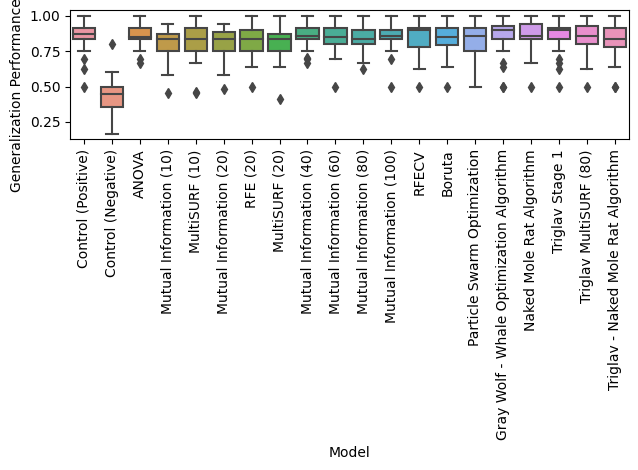

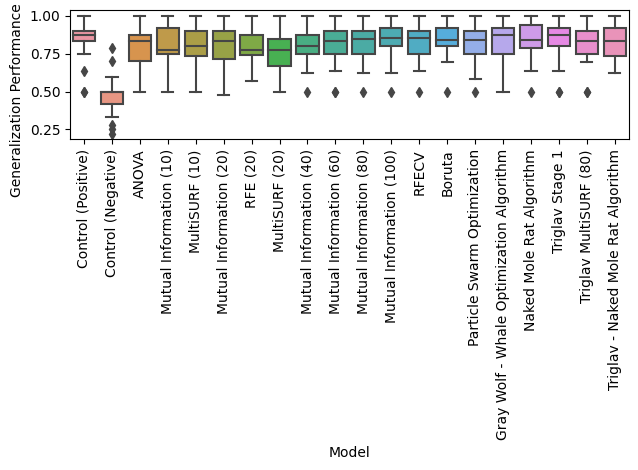

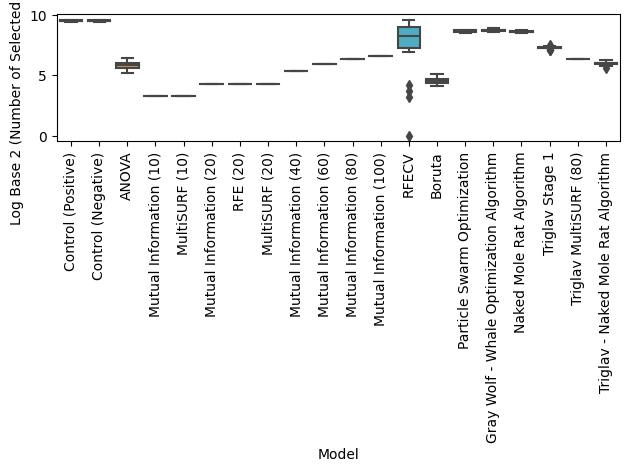

In [28]:
    arr_final = np.asarray(tmp_base)
    
    model_subset = ["Control (Positive)", "Control (Negative)", 
                    "Mutual Information (40)", "ANOVA",
                    "RFE (20)", "RFECV", "Boruta", "Mutual Information (80)", "Mutual Information (60)", "Mutual Information (100)",
                    "Particle Swarm Optimization", "Artificial Bee Colony Optimizaton", "Gray Wolf - Whale Optimization Algorithm", "Naked Mole Rat Algorithm",
                    "MultiSURF (20)", "Triglav Stage 1", "Triglav - Naked Mole Rat Algorithm", "Triglav MultiSURF (80)",
                    "Mutual Information (10)", "Mutual Information (20)", "MultiSURF (10)"]
    
    model_ss = [True if x[0] in model_subset else False for x in arr_final]
    
    arr_final = arr_final[model_ss]
    
    exp_arr = pd.DataFrame(np.asarray(tmp_base), columns = ["Model", "Generalization Performance (ETC)", 
                                                            "Generalization Performance (LSVC)", 
                                                            "Features", "Number of Selected Features"], dtype = "object")
    
    exp_arr["Log Base 2 (Number of Selected Features)"] = np.log2(exp_arr["Number of Selected Features"].values.astype(int))
    
    exp_arr.to_csv("exp_arr_pa.csv")
    
    exp_arr = pd.DataFrame(arr_final, columns = ["Model", "Generalization Performance (ETC)", 
                                                            "Generalization Performance (LSVC)", 
                                                         "Features", "Number of Selected Features"], dtype = "object")
    
    exp_arr["Log Base 2 (Number of Selected Features)"] = np.log2(exp_arr["Number of Selected Features"].values.astype(int))
    
    exp_arr.to_csv("exp_arr_ss_pa.csv")
    
    exp_arr["Generalization Performance (ETC)"] = exp_arr["Generalization Performance (ETC)"].astype(float)
    exp_arr["Generalization Performance (LSVC)"] = exp_arr["Generalization Performance (LSVC)"].astype(float)
    
    ax = sns.boxplot(x = "Model", y = "Generalization Performance (ETC)", hue = "Model", 
                data = exp_arr, dodge = False)
    legend = ax.legend()
    legend.remove()
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    ax = sns.boxplot(x = "Model", y = "Generalization Performance (LSVC)", hue = "Model", 
                     data = exp_arr, dodge = False)
    legend = ax.legend()
    legend.remove()
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    ax = sns.boxplot(x = "Model", y = "Log Base 2 (Number of Selected Features)", hue = "Model", 
                     data = exp_arr, dodge = False)
    legend = ax.legend()
    legend.remove()
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()
    plt.close()
